### Set-up

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import yaml
import os
import sys
import random
sys.path.append("seg_anything/")
import argparse
import onnxruntime
from PIL import Image
from semseg.utils.visualize import generate_palette
from semseg.utils.utils import timer
from infer_make_label import SemSeg
from seg_anything.segment_anything import sam_model_registry, SamPredictor
from visualization import *

### Initialize SAM model

In [2]:
# path to the sam model
sam_checkpoint = "seg_anything/notebooks/sam_vit_h_4b8939.pth" 
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

### 1: Use SAM to directly generate pseudo labels
Segment anything model takses input points as cues to generate segmentation mask

Since in the collected data, the region in front of the road must be drivable in must cases. Therefore, it is possible for us to select the points on the bottom of the image as input points for SAM to automatically generate labels

#### Example 

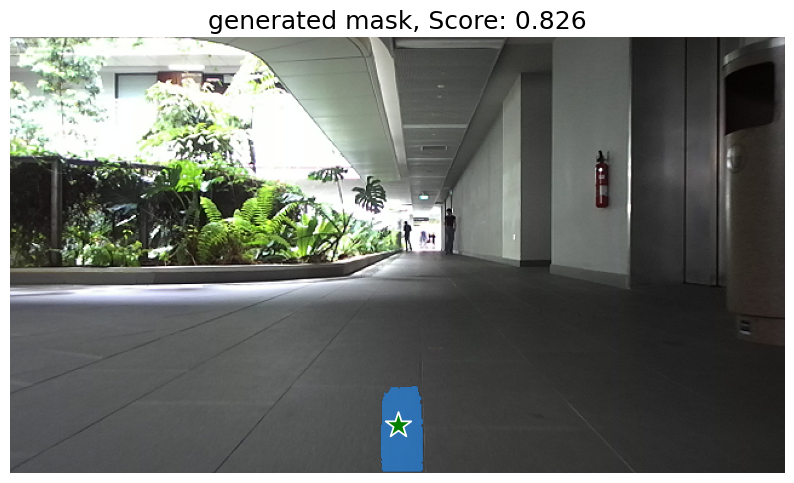

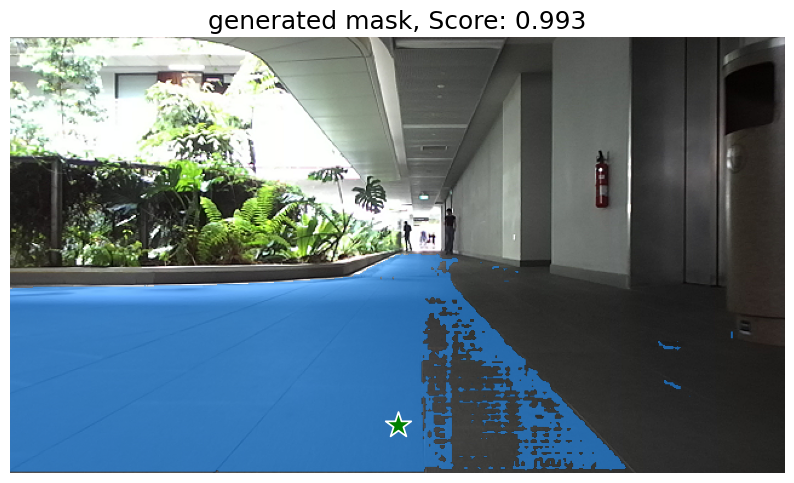

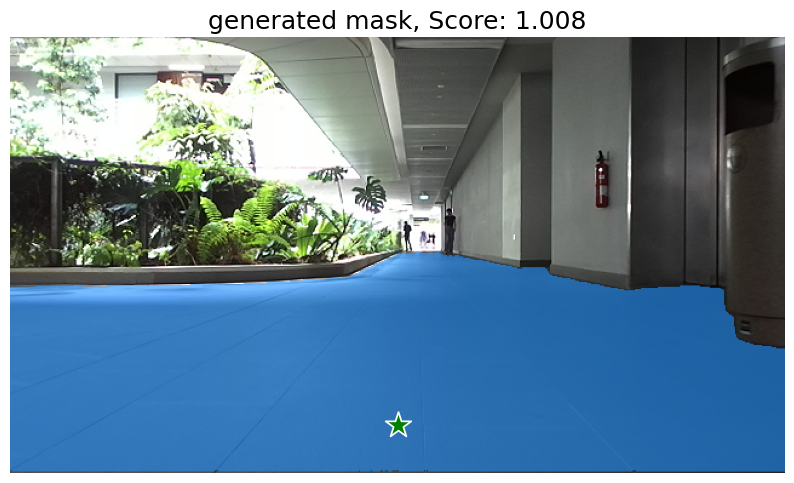

In [25]:
# first generate some road_mask proposals
image_path = 'docs/test_image.png'
image = cv2.imread(image_path)[:,:,:3]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)

input_point = np.array([[320, 320]])
input_label = np.array([1])
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"generated mask, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

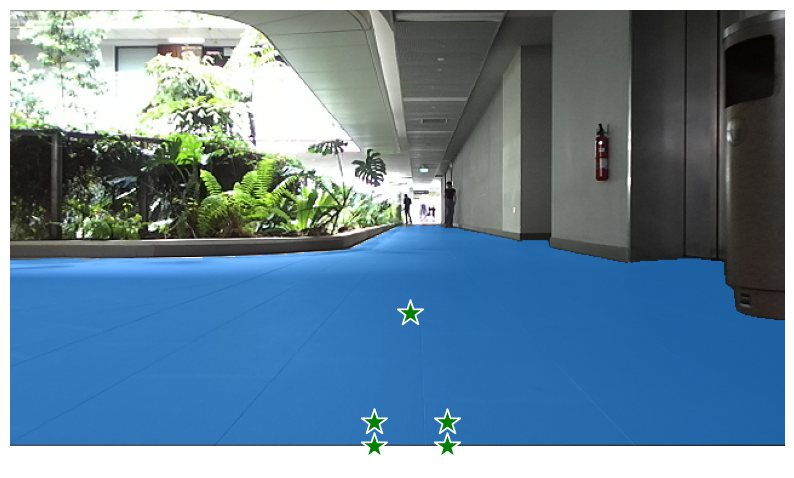

In [26]:
# use the generated mask with the largest region for further road extraction and you can also try to use the best mask
# with the highest score

input_point = np.array([[360,340], [330, 250],[300,340],[300,360],[360,360]])   #here some points belong to the road are selected
input_label = np.ones(shape=input_point.shape[0])

foreground_counts = np.sum(logits, axis=(1, 2))       # Choose the model's largest mask
mask_input = logits[np.argmax(foreground_counts)]
# mask_input = logits[np.argmax(scores), :, :]        # Choose the model's best mask
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca(),False)
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

#### Generate the mask and save the label

In [27]:
"""
def a data generation function:
image_path: input the image dir
save_path:  the label saving dir
mode: 0: save the visualization results 1: save the training label 
the label is save in a png, you can also modify the code to the format you need 
"""

def make_label(image_path,save_path,mode=1):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)
    input_point = np.array([[320,200]])                        # The inital input point
    input_label = np.array([1])
    
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    
    foreground_counts = np.sum(logits, axis=(1, 2))            # Choose the model's largest mask
    mask_input = logits[np.argmax(foreground_counts)]
    
    # mask_input = logits[np.argmax(scores), :, :]             # Choose the model's best mask
    
    input_point = np.array([[280,340], [360, 340],[320,280]])  # The final input point
    input_label = np.array([1,1,1])
    
    masks, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        mask_input=mask_input[None, :, :],
        multimask_output=False,
    )
    
    if mode==1:
        masks = np.array(masks)
        masks = np.transpose(masks,[1,2,0])
        masks = np.concatenate((masks, masks, masks), axis=2)
        masks = np.uint8(masks)
        cv2.imwrite(save_path,masks)
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_mask(masks, plt.gca(),False)
        show_points(input_point, input_label, plt.gca())
        plt.axis('off')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=100)
        plt.close()


In [ ]:
"""
generate labels using sam
"""
image_dir  = 'data/ntu/other/image_new/'
save_dir   = 'data/ntu/labels/train'
image_list = os.listdir(image_dir)
for image_name in image_list:
    print(image_name)
    image_path = os.path.join(image_dir,image_name)
    save_path  = os.path.join(save_dir,image_name)
    make_label(image_path,save_path)

### 2: Use a pretrained model and SAM to generate pseudo labels
Some of the gererated labels may not have a good quality using the first method due to: complex features of the road, inapproporiate input points, motion blue,robot movement, etc. 
To tackle the problem, there are some possible ways:
1. Delete the bad quality labels using the visualization results and use lebeling tools like labelme for data labeling. Note: The latest version of labelme also support weakly supervised data labeling with UI interface, it is also a good choice to use labelme to generate the mask
2. Generate more reasonable input points. Suppose we already have a road segmentation model (maybe witt domain gap, e.g. pretrained on public dataset or model train with few samples), we can use it to generate the input points which are more reasonable

Note: It can support multiclass label generation, however, in this notebook, only single class label generation process is implemented as it is only for road segmentation

In [6]:
"""
This function aims to random select input points from the prediction of a pretrained model
num_points: select how many points
Note: this function simply randamly selected n points, it can also be modified to selelect n points with the highest confidence

"""
def select_random_foreground_points(segmap, num_points=10):
    foreground_indices = np.where(segmap == 1)                   # CAN BE MODIFIED TO MULTICLASS LABEL GENERATION
    selected_points_indices = random.sample(range(len(foreground_indices[0])), num_points)
    selected_points = np.array([(foreground_indices[1][idx], foreground_indices[0][idx]) for idx in selected_points_indices])
    ones_array = np.ones(num_points, dtype=int)
    return selected_points, ones_array


#### Example

Original Image Size > 360x640

Inference Image Size > 480x864

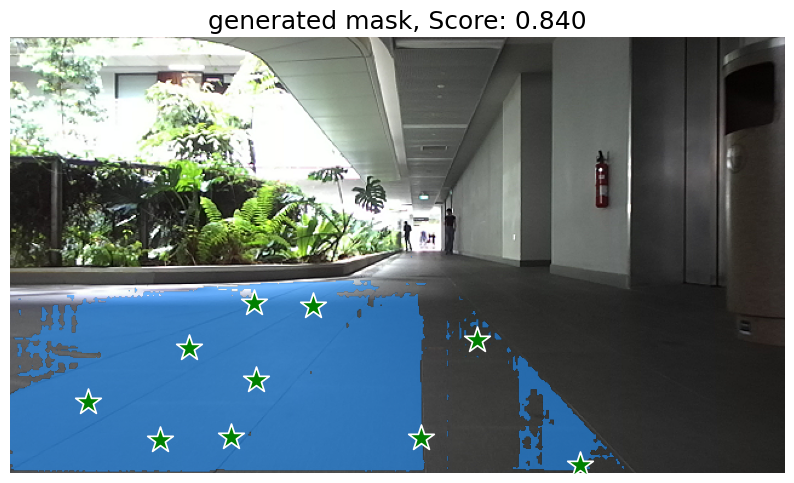

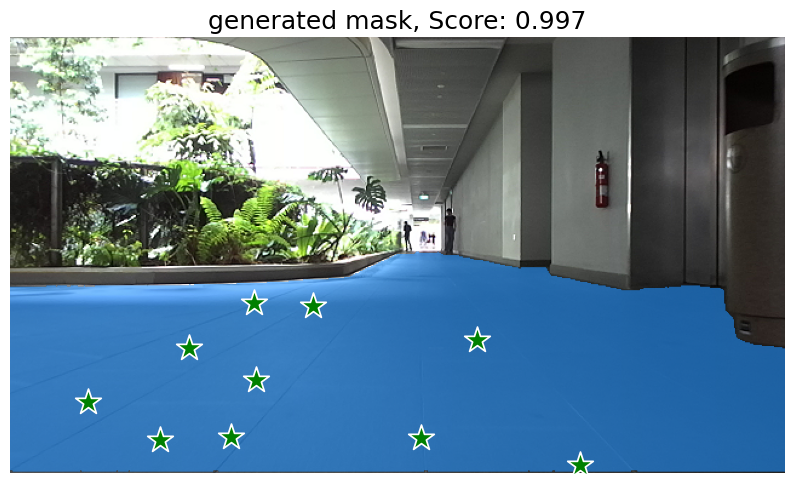

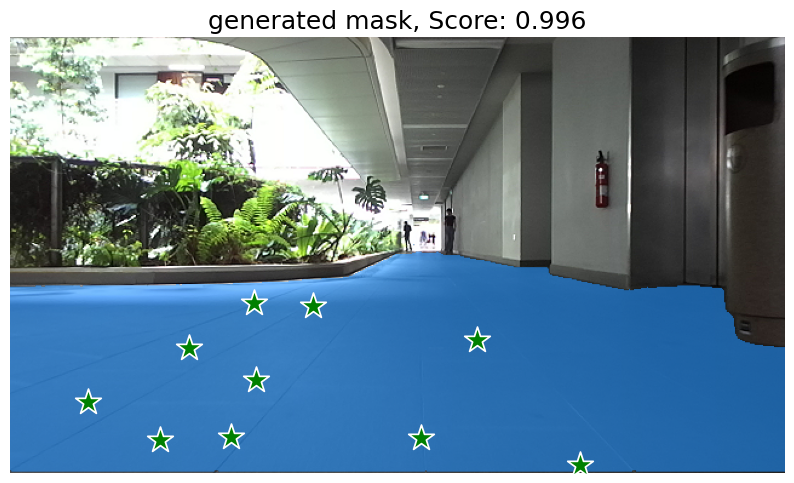

In [13]:
# first generate some road_mask proposals
image_path = 'docs/test_image.png'
image = cv2.imread(image_path)[:,:,:3]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)

config = 'configs/custom.yaml'                        #this is the road segmentation model train on bdd100k dataset
with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.SafeLoader)
semseg = SemSeg(cfg)                                  # Define the model here
segmap = semseg.predict(str(image_path), cfg['TEST']['OVERLAY'])
segmap = segmap.numpy()

input_point,input_label = select_random_foreground_points(segmap)

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"generated mask, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

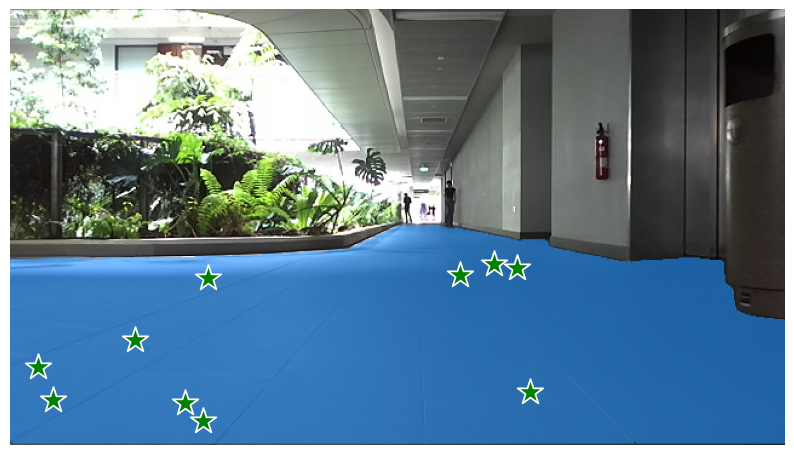

In [11]:
foreground_counts = np.sum(logits, axis=(1, 2))       # Choose the model's largest mask
mask_input = logits[np.argmax(foreground_counts)]
# mask_input = logits[np.argmax(scores), :, :]        # Choose the model's best mask
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca(),False)
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

#### Generaet labels

In [20]:
"""
def a data generation function:
image_path: input the image dir
save_path:  the label saving dir
mode: 0: save the visualization results 1: save the training label 
the label is save in a png, you can also modify the code to the format you need 

In this function, the number of randomly selected point can be different
"""

def make_label2(image_path,save_path,model,mode=1):
    segmap = model.predict(str(image_path), 'false')
    segmap = segmap.numpy()
    input_point,input_label = select_random_foreground_points(segmap,5)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)
    
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    
    foreground_counts = np.sum(logits, axis=(1, 2))            # Choose the model's largest mask
    mask_input = logits[np.argmax(foreground_counts)]
    
    # mask_input = logits[np.argmax(scores), :, :]             # Choose the model's best mask
    input_point,input_label = select_random_foreground_points(segmap,10)
    masks, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        mask_input=mask_input[None, :, :],
        multimask_output=False,
    )
    
    if mode==1:
        masks = np.array(masks)
        masks = np.transpose(masks,[1,2,0])
        masks = np.concatenate((masks, masks, masks), axis=2)
        masks = np.uint8(masks)
        cv2.imwrite(save_path,masks)
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_mask(masks, plt.gca(),False)
        show_points(input_point, input_label, plt.gca())
        plt.axis('off')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=100)
        plt.close()
        # plt.show()


Original Image Size > 360x640

Inference Image Size > 480x864

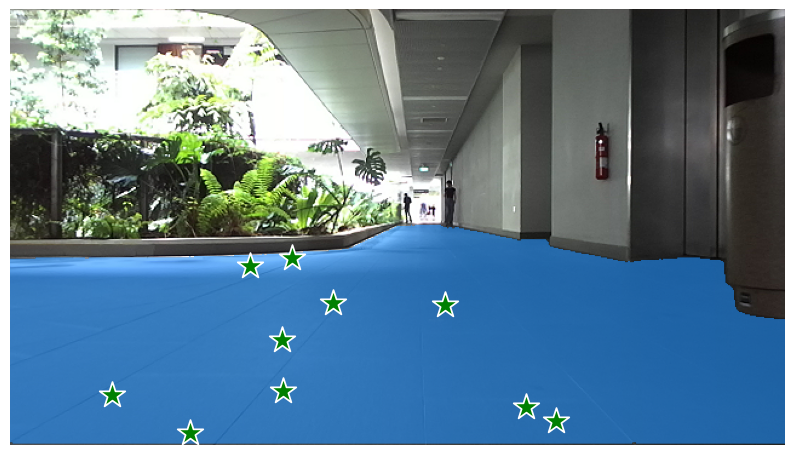

In [21]:
"""
generate labels using sam and pretrain_data
"""
config = 'configs/custom.yaml'                        #this is the road segmentation model train on bdd100k dataset
with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.SafeLoader)
semseg = SemSeg(cfg)

image_dir  = 'data/ntu/other/image_new/'
save_dir   = 'data/ntu/labels/train'
image_list = os.listdir(image_dir)
for image_name in image_list:
    print(image_name)
    image_path = os.path.join(image_dir,image_name)
    save_path  = os.path.join(save_dir,image_name)
    make_label(image_path,save_path)